In [1]:
import os
import shutil
os.chdir('..')

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns

sns.set_context("notebook", font_scale=1.4)
cmap = sns.diverging_palette(220, 10, as_cmap=True)

tmp_dir = "tmp_dir"
os.makedirs(tmp_dir, exist_ok=True)

# Evaluation

* The goal of this notebook is to provide an end-to-end example for evaluating recommender algorithms. 
* In the previous [Model Selection Notebook](https://github.com/fidelity/mab2rec/blob/main/notebooks/3_model_selection.ipynb), imagine that we identified a small set of recommenders with good performance.  
* In this notebook, we stress test these top contender algorithms further.  
* For input data, we use the famous [MovieLens 100K Dataset](https://grouplens.org/datasets/movielens/100k/). 
* The goal is not to build the best recommender for MovieLens but to showcase an end-to-end example of training recommenders with detailed evaluations to compare the different approaches.
* For recommendation algorithm, we take advantage of [MABWiser](https://github.com/fidelity/mabwiser) ([IJAIT'21](https://www.worldscientific.com/doi/abs/10.1142/S0218213021500214), [ICTAI'19](https://ieeexplore.ieee.org/document/8995418)) for bandit policies. 
* For performance evaluation, we employ [Jurity](https://github.com/fidelity/jurity) for various metrics.

# Input Data

* Inut data is as described in [Data Overview](https://github.com/fidelity/mab2rec/blob/main/notebooks/1_data_overview.ipynb).

In [2]:
# Input data
train_data = "data/ml100k/data_train.csv"
test_data = "data/ml100k/data_test.csv"

user_features = "data/ml100k/features_user.csv"
item_features = "data/ml100k/features_item.csv"

# Read data
train_df = pd.read_csv(train_data)
test_df = pd.read_csv(test_data)

user_features_df = pd.read_csv(user_features)
item_features_df = pd.read_csv(item_features)

# Recommenders

* Below we specify **a set of recommenders** to evaluate.
* In practice, we would select a small set of candidate algorithms with [Model Selection](https://github.com/fidelity/mab2rec/blob/main/notebooks/3_model_selection.ipynb).
* As shown in [model selection](https://github.com/fidelity/mab2rec/blob/main/notebooks/3_model_selection.ipynb), we benchmark several algorithms on a **validation dataset** or using **cross validation**. 
* This allows us avoid overfitting on the test data by considering a large number of algorithms repeatedly evaluated on train data.


In [3]:
from mab2rec import BanditRecommender, LearningPolicy, NeighborhoodPolicy

# Set of recommenders
recommenders = {
      "Random": BanditRecommender(learning_policy=LearningPolicy.Random()),
      "LinGreedy": BanditRecommender(learning_policy=LearningPolicy.LinGreedy(epsilon=0.1)),
      "LinTS": BanditRecommender(learning_policy=LearningPolicy.LinTS()),
      "ClustersTS": BanditRecommender(learning_policy=LearningPolicy.ThompsonSampling(), 
                                      neighborhood_policy=NeighborhoodPolicy.Clusters(n_clusters=10)),
      "LinUCB": BanditRecommender(learning_policy=LearningPolicy.LinUCB(alpha=1.0))
}

recommenders

{'Random': <mab2rec.rec.BanditRecommender at 0x1ac333bbe50>,
 'LinGreedy': <mab2rec.rec.BanditRecommender at 0x1ac333bb7c0>,
 'LinTS': <mab2rec.rec.BanditRecommender at 0x1ac333bbf10>,
 'ClustersTS': <mab2rec.rec.BanditRecommender at 0x1ac333bbfd0>,
 'LinUCB': <mab2rec.rec.BanditRecommender at 0x1ac1fd4ba30>}

# Metrics

* Let's define **the list of evaluation metrics** from [Jurity](https://github.com/fidelity/jurity) to compare the different recommenders.. 
* Recommendation metrics include `AUC`, `CTR`, `Precision`, `Recall`, `NDCG`, and `MAP`.
* See [Jurity documentation](https://fidelity.github.io/jurity/about_reco.html#) for the defintions of these metrics.

In [4]:
from jurity.recommenders import BinaryRecoMetrics, RankingRecoMetrics

# Column names for the response, user, and item id columns
metric_params = {'click_column': 'score', 'user_id_column': 'user_id', 'item_id_column':'item_id'}

# Evaluate peformance at different k-recommendations
top_k_list = [3, 5, 10]

# List of metrics to benchmark
metrics = []
for k in top_k_list:
    metrics.append(BinaryRecoMetrics.AUC(**metric_params, k=k))
    metrics.append(BinaryRecoMetrics.CTR(**metric_params, k=k))
    metrics.append(RankingRecoMetrics.Precision(**metric_params,  k=k))
    metrics.append(RankingRecoMetrics.Recall(**metric_params, k=k))
    metrics.append(RankingRecoMetrics.NDCG(**metric_params, k=k))
    metrics.append(RankingRecoMetrics.MAP(**metric_params, k=k))
    
metrics

# Benchmark 

* Run **benchmark** function to train each of the recommender algorithms on the train data, generate recommendations on the test data and evaluate the results using the list of evaluation metrics.
* Notice that this benchmarking differs from the benchmarking in [Model Selection](https://github.com/fidelity/mab2rec/blob/main/notebooks/3_model_selection.ipynb) that used cross-validation `cv` on train data. 

In [5]:
from mab2rec.pipeline import benchmark

# Benchmark the set of recommenders for the list of metrics 
# using training data and user features scored on test data 
reco_to_results, reco_to_metrics = benchmark(recommenders, 
                                             metrics=metrics,
                                             train_data=train_data, 
                                             test_data=test_data,
                                             user_features=user_features)

# Evaluation

* Great! We now have the recommended results, `reco_to_results`, and the evaluation metrics for each of the algorithms, `reco_to_metrics`. 
* Next, we perform a detailed analysis to confirm that the algorithms are behaving as expected.
* We compare the relative performance of the algorithms using a range of metrics.

## Recommendation Metrics

* We start by analyzing standard recommender metrics such as `CTR`, `Precision`, `Recall` and `NDCG`.
* Each plot displays the value (y-axis) of a given metric at different _top-k_ (x-axis) for each of the algorithms (different lines).
* We observe that `LinGreedy` performs best on almost all metrics, except for `AUC` where `ClustersTS` does better.

{'Random': {'AUC(score)@3': 0.5154761904761904, 'CTR(score)@3': 0.2112676056338028, 'Precision@3': 0.04950495049504949, 'Recall@3': 0.00774496333427291, 'NDCG@3': 0.014186541542204544, 'MAP@3': 0.0286028602860286, 'AUC(score)@5': 0.45335276967930027, 'CTR(score)@5': 0.2222222222222222, 'Precision@5': 0.05544554455445545, 'Recall@5': 0.013086241155909124, 'NDCG@5': 0.02060279415286892, 'MAP@5': 0.024983498349834984, 'AUC(score)@10': 0.47701304543409806, 'CTR(score)@10': 0.2261904761904762, 'Precision@10': 0.05643564356435644, 'Recall@10': 0.04335860418853606, 'NDCG@10': 0.03872990879686032, 'MAP@10': 0.022072379006608144}, 'LinGreedy': {'AUC(score)@3': 0.3757142857142857, 'CTR(score)@3': 0.4666666666666667, 'Precision@3': 0.11551155115511552, 'Recall@3': 0.02798006510530447, 'NDCG@3': 0.04174187216863834, 'MAP@3': 0.07755775577557755, 'AUC(score)@5': 0.3646505376344086, 'CTR(score)@5': 0.4918032786885246, 'Precision@5': 0.11881188118811879, 'Recall@5': 0.05198073722510852, 'NDCG@5': 0.0

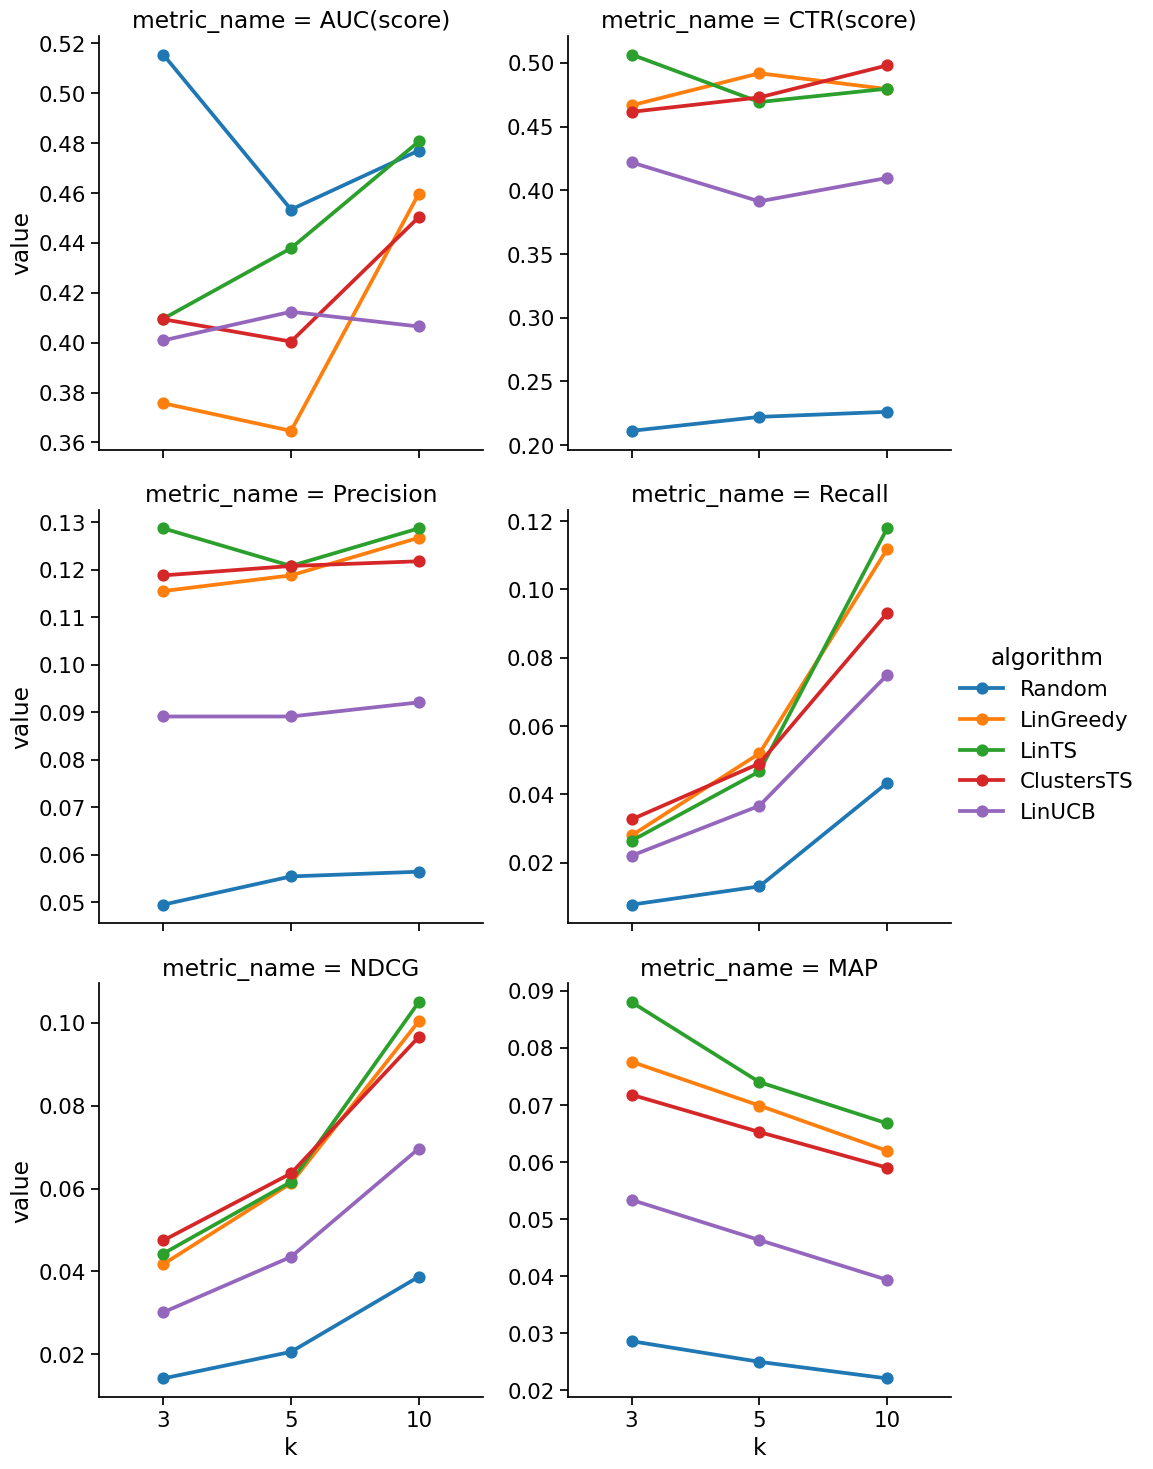

In [44]:
from mab2rec.visualization import plot_metrics_at_k

# Plot each metric across all algorithms at different k
plot_metrics_at_k(reco_to_metrics, col_wrap=2)
print(reco_to_metrics)

Os resultados obtidos foram os mesmos mostrados na biblioteca

Porém, as métricas foram calculadas por eles mesmos, vamos tentar calcular outras métricas, nós mesmos

In [51]:
from mab2rec.pipeline import train

rec = BanditRecommender(learning_policy=LearningPolicy.LinUCB(alpha=1.0), top_k=5)

train(rec, data=train_data, user_features=user_features)

In [52]:
df_test = pd.read_csv(test_data)
user_features_df = pd.read_csv(user_features)
contexts = df_test.merge(user_features_df, on='user_id').drop(columns=['user_id', 'item_id', 'response']).values

recomendations = rec.recommend(contexts)

df_test = df_test.reset_index(drop=True)

hits = 0
for i, interaction in df_test.iterrows():
    if interaction['item_id'] in recomendations[i]:
        hits += 1

print(f'Hits: {hits}')
print(f'Total: {len(df_test)}')
print(f'HR: {hits/len(df_test)}')

Hits: 106
Total: 4797
HR: 0.022097144048363562


In [54]:
df_test = pd.read_csv(test_data)
user_features_df = pd.read_csv(user_features)
contexts = user_features_df[user_features_df['user_id'].isin(df_test['user_id'])].drop(columns=['user_id']).values  # Apenas contextos (features dos usuários) presentes no conjunto de teste

recomendations = rec.recommend(contexts)

recs_list = []
for i, user_id in enumerate(df_test['user_id'].unique().tolist()):
    for reco in recomendations[i]:
        recs_list.append([user_id, reco])

df_recs = pd.DataFrame(recs_list, columns=['user_id', 'item_id'])

df_set = df_test.merge(df_recs, on=['user_id', 'item_id'], how='inner')

df_set['response'].mean()

0.391304347826087

Com topN (topk) = 5, o resultado do CTR deu exatamente o mesmo que foi calculado pela lib

## Agora, vamos tentar fazer o mesmo usando as nossas embeddings ao invés de usar a deles

In [55]:
from sklearn.preprocessing import LabelEncoder

In [64]:
df_train = pd.read_csv(train_data)
df_test = pd.read_csv(test_data)

df_full = pd.concat([df_train, df_test])

df_full['user_id'] = LabelEncoder().fit_transform(df_full['user_id'])
df_full['item_id'] = LabelEncoder().fit_transform(df_full['item_id'])

df_train = df_full.iloc[:len(df_train)]
df_test = df_full.iloc[len(df_train):]

In [65]:
import implicit
from scipy.sparse import csr_matrix
from implicit.nearest_neighbours import bm25_weight

num_users = df_full['user_id'].nunique()
num_items = df_full['item_id'].nunique()

import numpy as np

In [66]:
# Cria a matriz esparsa
sparse_matrix = csr_matrix((np.ones(len(df_train)), (df_train['user_id'], df_train['item_id'])), shape=(num_users, num_items))
sparse_matrix = bm25_weight(sparse_matrix, K1=100, B=0.8)

# Treina o modelo
model = implicit.als.AlternatingLeastSquares(factors=100)
model.fit(sparse_matrix)

print(model.user_factors)

  0%|          | 0/15 [00:00<?, ?it/s]

[[ 1.106768    0.63417655  0.86797667 ... -0.09354086 -0.09004543
  -1.6798574 ]
 [ 0.84353197 -0.82465416  0.9184452  ...  1.739418    2.349367
   1.0276006 ]
 [ 0.3455104  -0.11864645 -1.1094191  ...  0.5685864   1.7644147
   0.08647593]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-1.8412603  -1.7617306  -1.5007432  ... -0.07623975 -0.44473764
  -1.0477654 ]
 [ 0.1490629  -1.06461    -0.01739667 ... -0.69993484 -1.7370304
   0.05585689]]


In [67]:
user_features_list = []

for user_id in df_train['user_id'].unique():
    user_factors = model.user_factors[user_id]
    user_features_list.append([user_id] + list(user_factors))

df_user_features = pd.DataFrame(user_features_list, columns=['user_id'] + [f'u{i}' for i in range(100)])
df_user_features

,user_id,u0,u1,u2,u3,u4,u5,u6,u7,u8,...,u90,u91,u92,u93,u94,u95,u96,u97,u98,u99
0,842,0.805896,-1.603693,1.478199,2.250901,0.938239,0.540506,-0.118964,2.111017,0.741474,...,0.521112,2.337546,1.388423,1.201003,-0.188096,-0.143023,2.132824,0.469626,0.211333,0.899396
1,143,1.055226,0.980287,0.761796,0.440513,1.020866,0.117397,0.470974,0.826660,0.583641,...,-0.600766,0.403701,-0.446137,4.015747,-0.813171,-0.558564,-0.691944,0.133316,0.638014,-0.880771
2,600,0.220304,1.176653,0.317575,1.838257,-0.674396,0.653120,0.652915,0.478980,2.436704,...,0.189409,1.079665,2.773399,0.896669,0.177990,0.095500,1.495306,0.146939,1.265537,-1.377185
3,750,1.730740,-2.326482,-0.750975,0.180443,2.277087,-0.428951,0.474231,0.685335,-0.303284,...,0.375590,1.175550,0.303999,2.284686,-0.019220,0.768823,-0.409812,1.671520,2.491822,0.051638
4,200,0.410240,0.223278,0.076653,1.703632,1.156673,0.295052,-0.056707,0.639178,0.853583,...,2.061349,-0.168758,-1.159063,1.283594,-0.500082,-0.094734,-0.048200,-2.222825,2.726443,2.119350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891,924,-0.526204,0.559835,0.130997,-0.170540,0.753595,-0.398767,-0.274902,-1.579126,-0.021225,...,0.965415,0.331553,0.292358,0.233510,-1.322199,1.830995,-0.296042,-0.881825,0.532191,0.535705
892,854,-0.042912,0.320357,-0.074226,-0.011076,0.118519,0.465381,-0.073523,0.150492,-0.514336,...,1.176254,0.253966,-0.124753,-0.079883,0.046073,0.465850,0.327703,0.377795,0.661280,0.059542
893,4,-0.041499,0.347233,-0.002492,0.082682,0.163033,0.358502,0.996160,0.959276,0.221374,...,-0.570631,0.205142,-0.448456,0.411061,0.016128,0.070394,-0.375965,0.191463,0.017811,0.097129
894,674,-0.224238,-0.549024,-1.563891,-0.100722,-0.366224,0.033262,0.323694,-0.177921,-0.365506,...,0.836955,0.504776,0.316073,0.746209,0.619807,0.429088,-0.158309,-0.031114,-0.409741,0.111276


In [68]:
reco_to_results, reco_to_metrics = benchmark(recommenders, 
                                             metrics=metrics,
                                             train_data=df_train, 
                                             test_data=df_test,
                                             user_features=df_user_features)

{'Random': {'AUC(score)@3': 0.5154761904761904, 'CTR(score)@3': 0.2112676056338028, 'Precision@3': 0.04950495049504949, 'Recall@3': 0.00774496333427291, 'NDCG@3': 0.014186541542204544, 'MAP@3': 0.0286028602860286, 'AUC(score)@5': 0.45335276967930027, 'CTR(score)@5': 0.2222222222222222, 'Precision@5': 0.05544554455445545, 'Recall@5': 0.013086241155909124, 'NDCG@5': 0.02060279415286892, 'MAP@5': 0.024983498349834984, 'AUC(score)@10': 0.47701304543409806, 'CTR(score)@10': 0.2261904761904762, 'Precision@10': 0.05643564356435644, 'Recall@10': 0.04335860418853606, 'NDCG@10': 0.03872990879686032, 'MAP@10': 0.022072379006608144}, 'LinGreedy': {'AUC(score)@3': 0.5103383458646616, 'CTR(score)@3': 0.40425531914893614, 'Precision@3': 0.06270627062706269, 'Recall@3': 0.011170528979206907, 'NDCG@3': 0.021437901333447022, 'MAP@3': 0.0418041804180418, 'AUC(score)@5': 0.40986085904416214, 'CTR(score)@5': 0.3372093023255814, 'Precision@5': 0.057425742574257435, 'Recall@5': 0.015662320420576893, 'NDCG@5'

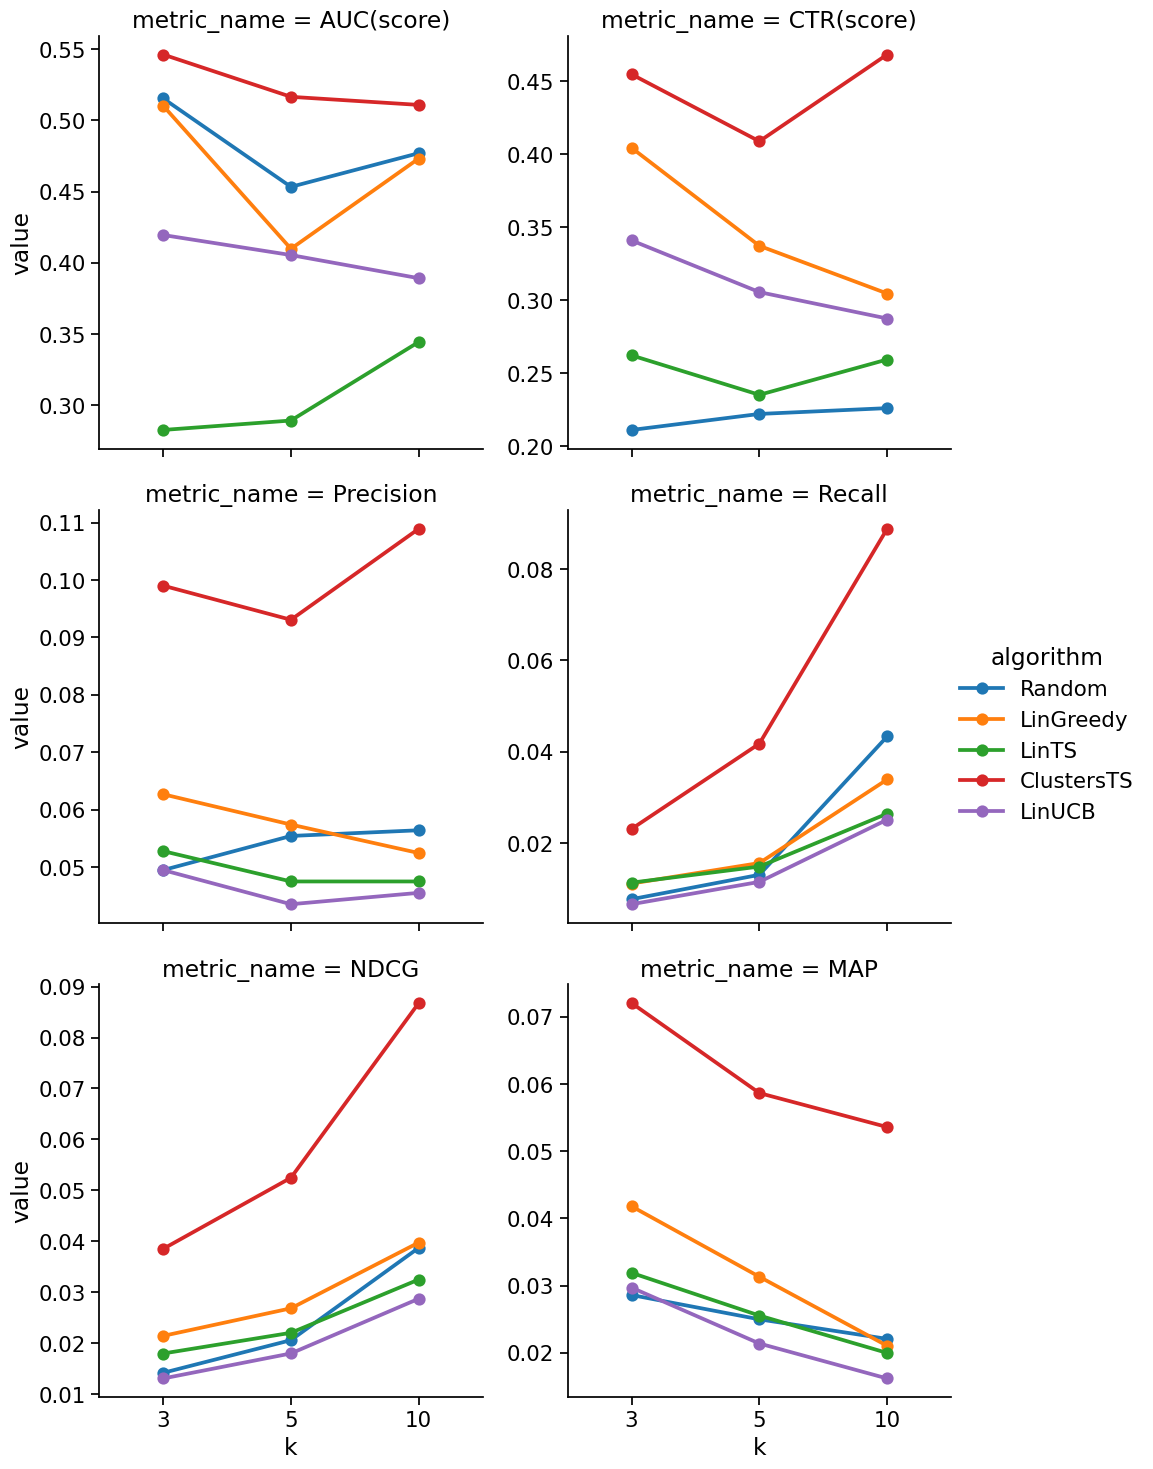

In [69]:
# Plot each metric across all algorithms at different k
plot_metrics_at_k(reco_to_metrics, col_wrap=2)
print(reco_to_metrics)

In [72]:
df_test['user_id'].isin(df_train['user_id']).value_counts()

True     2839
False    1958
Name: user_id, dtype: int64

In [73]:
df_test = df_test[df_test['user_id'].isin(df_train['user_id'])]
len(df_test)

2839

In [74]:
reco_to_results, reco_to_metrics = benchmark(recommenders, 
                                             metrics=metrics,
                                             train_data=df_train, 
                                             test_data=df_test,
                                             user_features=df_user_features)

{'Random': {'AUC(score)@3': 0.4584615384615385, 'CTR(score)@3': 0.34210526315789475, 'Precision@3': 0.07878787878787878, 'Recall@3': 0.03178009864674882, 'NDCG@3': 0.03250214110768952, 'MAP@3': 0.054545454545454536, 'AUC(score)@5': 0.46852425180598556, 'CTR(score)@5': 0.2714285714285714, 'Precision@5': 0.0690909090909091, 'Recall@5': 0.037936452097219915, 'NDCG@5': 0.03894923331080372, 'MAP@5': 0.04351515151515152, 'AUC(score)@10': 0.4904717275851296, 'CTR(score)@10': 0.25384615384615383, 'Precision@10': 0.06000000000000001, 'Recall@10': 0.05038760601361447, 'NDCG@10': 0.050086775156823006, 'MAP@10': 0.03491991341991342}, 'LinGreedy': {'AUC(score)@3': 0.5833333333333334, 'CTR(score)@3': 0.36363636363636365, 'Precision@3': 0.07272727272727272, 'Recall@3': 0.010846352993411818, 'NDCG@3': 0.02140151621418358, 'MAP@3': 0.04444444444444444, 'AUC(score)@5': 0.5592334494773519, 'CTR(score)@5': 0.2545454545454545, 'Precision@5': 0.050909090909090925, 'Recall@5': 0.011365833512892335, 'NDCG@5':

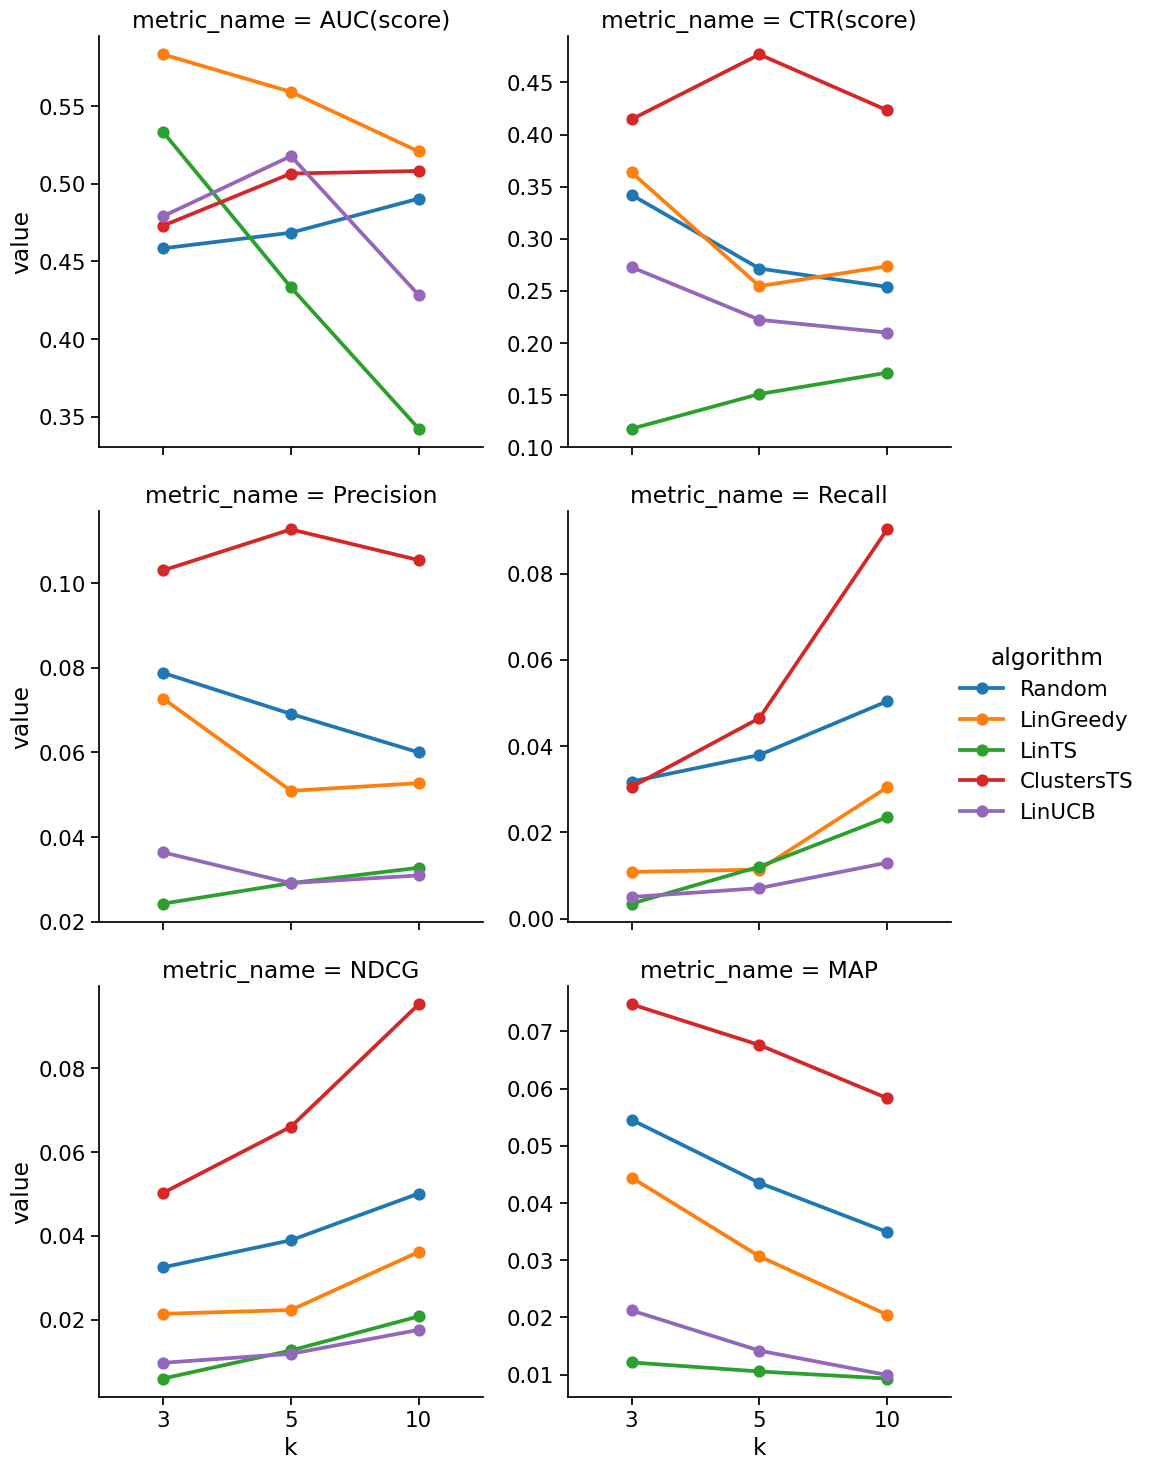

In [75]:
# Plot each metric across all algorithms at different k
plot_metrics_at_k(reco_to_metrics, col_wrap=2)
print(reco_to_metrics)

Não tivemos resultados muito bons... Vamos deixar o código em uma função, para testarmos parâmetros diferentes, e ver se muda algo

In [112]:
def test(use_weight=False, K1=100, B=0.8, factors=100, filter_test=True):
    df_train = pd.read_csv(train_data)
    df_test = pd.read_csv(test_data)

    df_full = pd.concat([df_train, df_test])

    df_full['user_id'] = LabelEncoder().fit_transform(df_full['user_id'])
    df_full['item_id'] = LabelEncoder().fit_transform(df_full['item_id'])

    df_train = df_full.iloc[:len(df_train)]
    df_test = df_full.iloc[len(df_train):]

    if filter_test:
        df_test = df_test[df_test['user_id'].isin(df_train['user_id'])]

    num_users = df_full['user_id'].nunique()
    num_items = df_full['item_id'].nunique()

    # Cria a matriz esparsa
    sparse_matrix = csr_matrix((np.ones(len(df_train)), (df_train['user_id'], df_train['item_id'])), shape=(num_users, num_items))
    if use_weight:
        updated_sparse_matrix = bm25_weight(sparse_matrix, K1=K1, B=B)
    else:
        updated_sparse_matrix = sparse_matrix

    # Treina o modelo
    model = implicit.als.AlternatingLeastSquares(factors=factors)
    model.fit(updated_sparse_matrix)

    user_features_list = []

    for user_id in df_train['user_id'].unique():
        user_factors = model.user_factors[user_id]
        user_features_list.append([user_id] + list(user_factors))

    df_user_features = pd.DataFrame(user_features_list, columns=['user_id'] + [f'u{i}' for i in range(factors)])

    reco_to_results, reco_to_metrics = benchmark(recommenders, 
                                             metrics=metrics,
                                             train_data=df_train, 
                                             test_data=df_test,
                                             user_features=df_user_features)
    
    plot_metrics_at_k(reco_to_metrics, col_wrap=2)
    print(reco_to_metrics)

    return model, sparse_matrix, df_user_features

  0%|          | 0/15 [00:00<?, ?it/s]

{'Random': {'AUC(score)@3': 0.4584615384615385, 'CTR(score)@3': 0.34210526315789475, 'Precision@3': 0.07878787878787878, 'Recall@3': 0.03178009864674882, 'NDCG@3': 0.03250214110768952, 'MAP@3': 0.054545454545454536, 'AUC(score)@5': 0.46852425180598556, 'CTR(score)@5': 0.2714285714285714, 'Precision@5': 0.0690909090909091, 'Recall@5': 0.037936452097219915, 'NDCG@5': 0.03894923331080372, 'MAP@5': 0.04351515151515152, 'AUC(score)@10': 0.4904717275851296, 'CTR(score)@10': 0.25384615384615383, 'Precision@10': 0.06000000000000001, 'Recall@10': 0.05038760601361447, 'NDCG@10': 0.050086775156823006, 'MAP@10': 0.03491991341991342}, 'LinGreedy': {'AUC(score)@3': 0.46634615384615385, 'CTR(score)@3': 0.48, 'Precision@3': 0.14545454545454545, 'Recall@3': 0.020954843130003942, 'NDCG@3': 0.04261691377196738, 'MAP@3': 0.11111111111111109, 'AUC(score)@5': 0.48327759197324416, 'CTR(score)@5': 0.4588235294117647, 'Precision@5': 0.14181818181818182, 'Recall@5': 0.0460401299328923, 'NDCG@5': 0.0630879784750

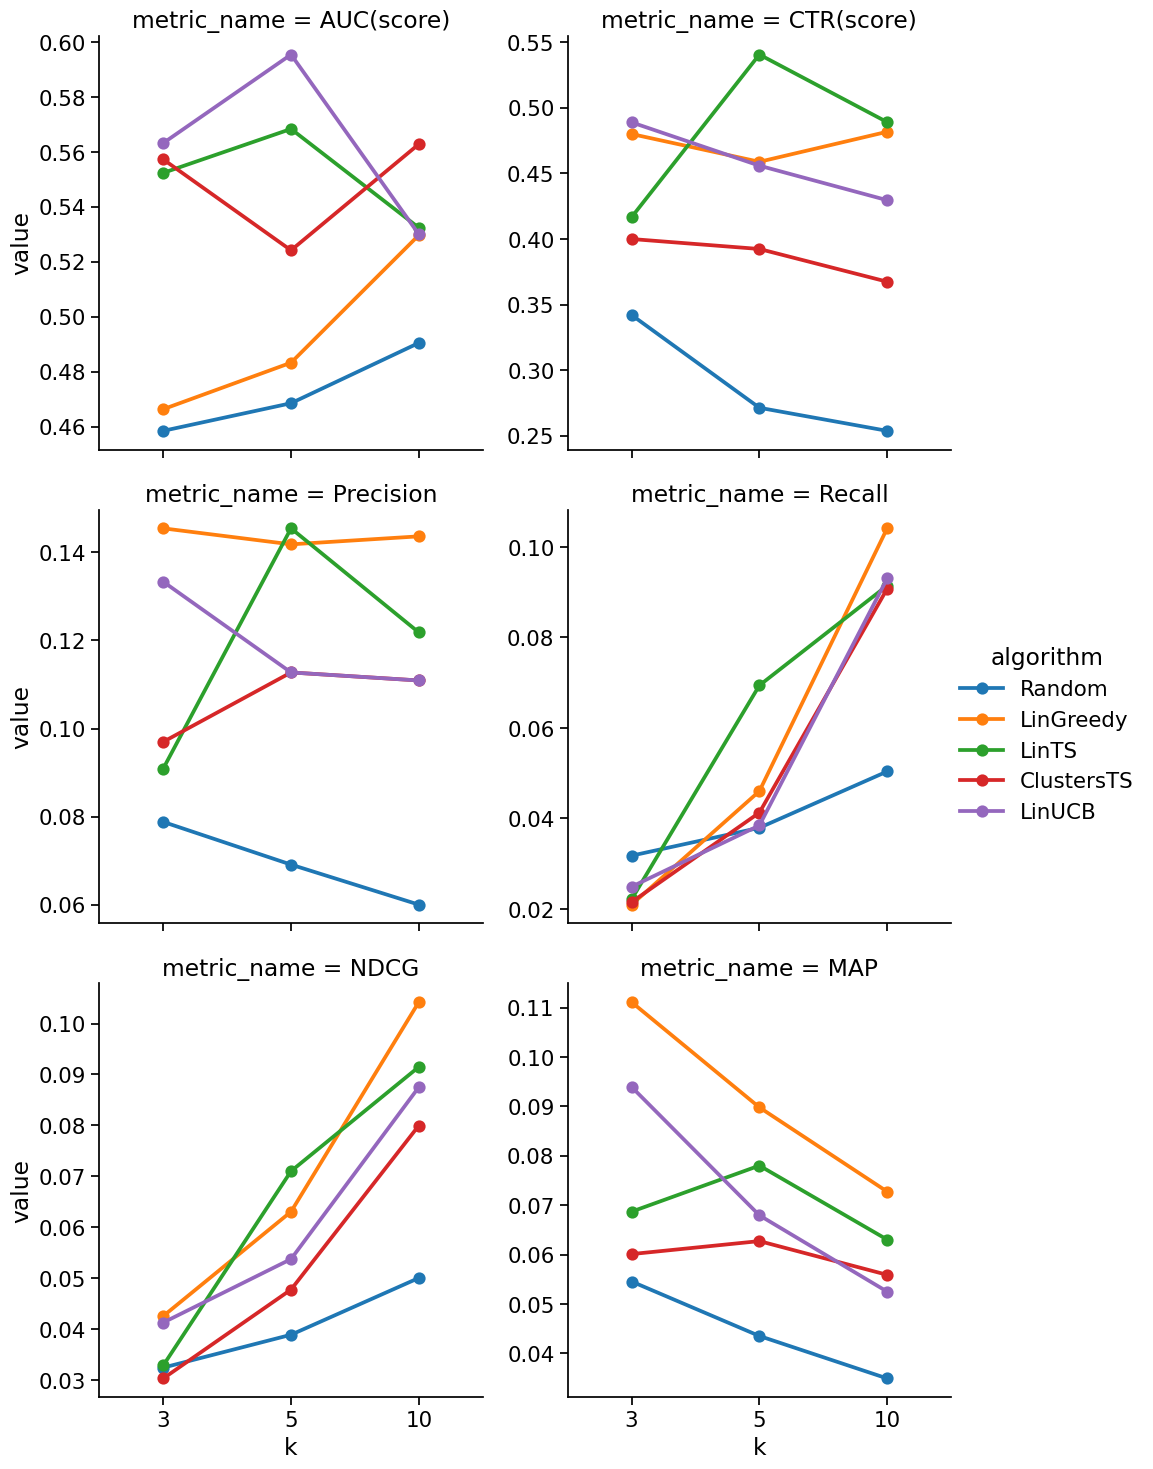

In [113]:
_ = test(
    use_weight=True, 
    K1=100,
    B=0.8,
    factors=10,
    filter_test=True
)

  0%|          | 0/15 [00:00<?, ?it/s]

{'Random': {'AUC(score)@3': 0.5154761904761904, 'CTR(score)@3': 0.2112676056338028, 'Precision@3': 0.04950495049504949, 'Recall@3': 0.00774496333427291, 'NDCG@3': 0.014186541542204544, 'MAP@3': 0.0286028602860286, 'AUC(score)@5': 0.45335276967930027, 'CTR(score)@5': 0.2222222222222222, 'Precision@5': 0.05544554455445545, 'Recall@5': 0.013086241155909124, 'NDCG@5': 0.02060279415286892, 'MAP@5': 0.024983498349834984, 'AUC(score)@10': 0.47701304543409806, 'CTR(score)@10': 0.2261904761904762, 'Precision@10': 0.05643564356435644, 'Recall@10': 0.04335860418853606, 'NDCG@10': 0.03872990879686032, 'MAP@10': 0.022072379006608144}, 'LinGreedy': {'AUC(score)@3': 0.6136900078678206, 'CTR(score)@3': 0.4305555555555556, 'Precision@3': 0.10231023102310231, 'Recall@3': 0.025227962710675532, 'NDCG@3': 0.041363812555028925, 'MAP@3': 0.08168316831683167, 'AUC(score)@5': 0.6111111111111112, 'CTR(score)@5': 0.43243243243243246, 'Precision@5': 0.09504950495049505, 'Recall@5': 0.037957857285872275, 'NDCG@5':

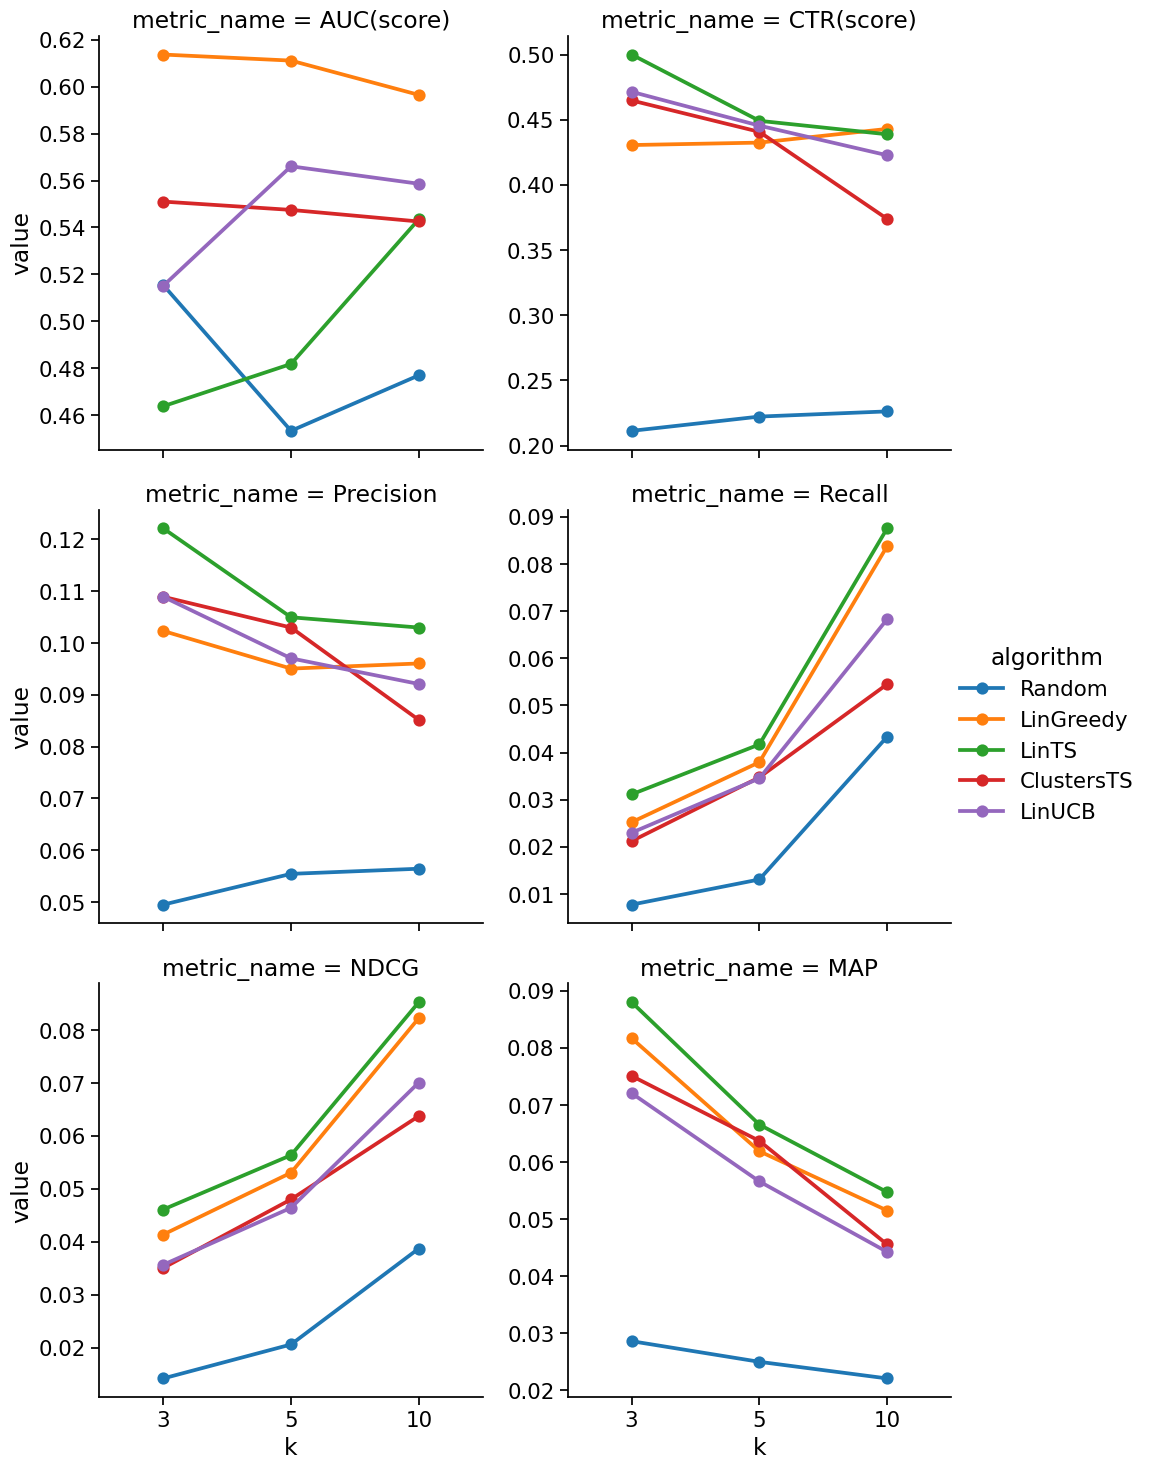

In [119]:
model, sparse_matrix, user_features_df = test(
    use_weight=True, 
    K1=100,
    B=0.8,
    factors=10,
    filter_test=False
)

In [120]:
rec = BanditRecommender(learning_policy=LearningPolicy.LinUCB(alpha=1.0), top_k=10)

train(rec, data=df_train, user_features=user_features_df)

contexts = df_test.merge(user_features_df, on='user_id').drop(columns=['user_id', 'item_id', 'response']).values

recomendations = rec.recommend(contexts)

df_test = df_test.reset_index(drop=True)

hits = 0
for i, interaction in df_test.iterrows():
    if interaction['item_id'] in recomendations[i]:
        hits += 1

print(f'Hits: {hits}')
print(f'Total: {len(df_test)}')
print(f'HR: {hits/len(df_test)}')

Hits: 122
Total: 2839
HR: 0.042972877773864035


In [134]:
# Cria a matriz esparsa
sparse_matrix = csr_matrix((np.ones(len(df_train)), (df_train['user_id'], df_train['item_id'])), shape=(num_users, num_items))
updated_sparse_matrix = bm25_weight(sparse_matrix, K1=100, B=0.8)
# Treina o modelo
model = implicit.als.AlternatingLeastSquares(factors=10)
model.fit(updated_sparse_matrix)

hits = 0
for i, interaction in df_test.iterrows():
    ids_recs, recommendations = model.recommend(userid=interaction['user_id'], user_items=sparse_matrix[interaction['user_id']], N=10)
    if interaction['item_id'] in ids_recs:
        hits += 1

print(f'Hits: {hits}')
print(f'Total: {len(df_test)}')
print(f'HR: {hits/len(df_test)}')

  0%|          | 0/15 [00:00<?, ?it/s]

Hits: 188
Total: 2839
HR: 0.06622050017611836
